# Option Pricing with Binomial Trees and Black-Scholes

This notebook explores various option pricing models and techniques, including:

- Implementation of the binomial tree method for European and American options
- Comparison of binomial tree prices with Black-Scholes analytical solutions
- Analysis of convergence and pricing errors as the number of binomial steps increases
- Examination of log-return distributions and their relationship to the binomial model
- Visualization of exercise boundaries for American options and the effect of volatility
- Pricing and analysis of barrier and Parisian options using binomial trees

Mathematical derivations, code implementations, and visualizations are provided to illustrate key concepts in computational finance and option pricing theory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import yfinance as yf
import math
from scipy.stats import norm

## Problem 1
a.
\begin{equation}
u = e^{\sigma \sqrt{\Delta t}} \\
d = 1/u = e^{- \sigma \sqrt{\Delta t}}\\
p= \frac{e^{r \Delta t} - d}{u-d} 
\end{equation}
<br>
where 
\begin{equation}
\Delta t = T/N
\end{equation}
c. As you can see below, the error decreases as N increases, but it will never be completely gone. With N > 200 however we can see the error is less than .00025 which is quite small and for N > 500 the error is about .0001 or lower. With N = 200 the predicted price is .002 which means it is accurate to the cent in most cases.

In [2]:
def calc_parameters(sigma, r, delta_t):
    u = np.exp(sigma * np.sqrt(delta_t))
    d = 1 / u
    p = (np.exp(r * delta_t) - d) / (u - d)
    return u , d , p

In [3]:
def euro_binomial_tree(S_0, sigma, r, K, T, N, option_type):
    delta_t = T/N
    u, d, p = calc_parameters(sigma, r, delta_t)
    price = 0
    for i in range(N+1):
        combos = math.factorial(N)/(math.factorial(i)*math.factorial(N-i))
        prob = combos*(p**i)*((1-p)**(N-i))
        final_price = S_0*(u**i)*(d**(N-i))
        if option_type == 'call':
            val = max(final_price - K, 0)
        else: 
            val = max(K - final_price, 0)
        disc_val = np.exp(-r*T)*val
        add = prob*disc_val
        price = price + add
    return price

In [4]:
def black_scholes(S, K, T, r, sigma, div, option_type='call'):
    q= div/S
    d1 = (np.log(S / K) + (r + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    gamma = np.exp(-q*T) * norm.pdf(d1)/(S*sigma*np.sqrt(T))
    vega = np.exp(-q*T) * S * np.sqrt(T) * norm.pdf(d1)

    if option_type == 'call':
        option_price = S * np.exp(-q*T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = np.exp(-q*T) * norm.cdf(d1)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q*T) * norm.cdf(-d1)
        delta = np.exp(-q*T) * (norm.cdf(d1) - 1)
    else:
        raise ValueError("Option type must be 'call' or 'put'.")

    return option_price, d1, d2, delta, gamma, vega

In [40]:
S_0 = 100
K=90
T=.5
sigma = .2
r = .04
option_type = 'put'
div = 0
N=1000
euro_binomial_tree(S_0, sigma, r, K, T, N, option_type)

1.3656558026710943

In [41]:
black_scholes(S_0, K, T, r, sigma, div, option_type)[0]

1.3654307081677857

In [42]:
option_type = 'call'
euro_binomial_tree(S_0, sigma, r, K, T, N, option_type)

13.147775205055588

In [43]:
black_scholes(S_0, K, T, r, sigma, div, option_type)[0]

13.147550110559806

In [12]:
S_0 = 100
K=90
T=.5
sigma = .2
r = .04
option_type = 'call'
div = 0
Ns = np.arange(25,1000, 5)
pricing_error_arr = []
for N in Ns:
    tree_price = euro_binomial_tree(S_0, sigma, r, K, T, N, option_type)
    bs_price = black_scholes(S_0, K, T, r, sigma, div, option_type)[0]
    error = abs(tree_price - bs_price)/bs_price
    pricing_error_arr.append(error)

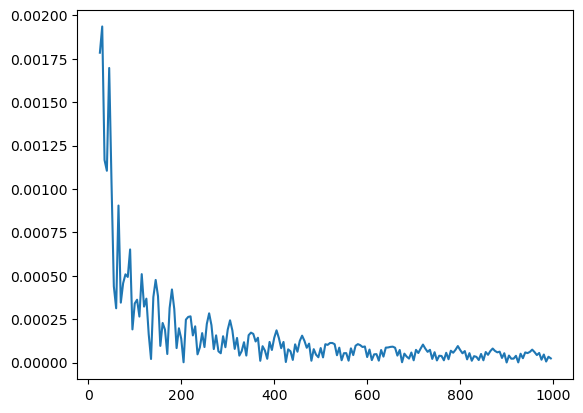

In [14]:
plt.plot(Ns,pricing_error_arr)

## Problem 2
(i)
We have the 
\begin{equation}
dS_{t} = r S_{t}dt + \sigma S_{t}dW_{t}
\end{equation}
We can use Ito's lemma to find 
\begin{equation}
d log(S) = f_{t}(S)dt + f_{S}(S)dS + \frac{1}{2}f_{SS}(S)(dS)^{2}
\\
f_{t}(S) = \frac{dlog(S)}{dt} = 0
\\
f_{S}(S) = \frac{dlog(S)}{dS} = \frac{1}{S}
\\
f_{SS}(S) = \frac{d^{2}log(S)}{dS^{2}} = \frac{-1}{S^{2}}
\\
(dS)^{2} = (r S_{t}dt + \sigma S_{t}dW_{t})^{2} = ...(dt^{2}) + ... dtdW_{t} + (\sigma S_{t}dW_{t})^{2} 
\\ dt^{2} = 0 , \ dtdW_{t} = 0 , \ dW_{t}^{2} = dt
\\
so \ (dS)^{2} = \sigma^{2} S_{t}^{2}dt
\\
then \ we \ get 
\ d log(S_{t}) = 0+ \frac{1}{S_{t}}(r S_{t}dt + \sigma S_{t}dW_{t}) - \frac{1}{2S^{2}}(\sigma^{2} S_{t}^{2}dt)
\\
 = (r - \frac{\sigma^{2}}{2})dt+ \sigma dW_{t}
\end{equation}
We can integrate both sides and get 
\begin{equation}
\int^{T}_{0} d log(S_{u}) = \int^{T}_{0} (r - \frac{\sigma^{2}}{2})du+ \int^{T}_{0} \sigma dW_{u}
\\
\int^{T}_{0} d log(S_{u}) = log(S_{T})-log(S_{0}) = log( \frac{S_{T}}{S_{0}})
\\
\int^{T}_{0} (r - \frac{\sigma^{2}}{2})du = (r - \frac{\sigma^{2}}{2}) (T-0) = (r - \frac{\sigma^{2}}{2})T
\\
\int^{T}_{0} \sigma dW_{u} = \sigma (W_{T}- W_{0}), \ W_{0} = 0 , \ \int^{T}_{0} \sigma dW_{u} = \sigma (W_{T})
\end{equation}

so we get 
\begin{equation}
log( \frac{S_{T}}{S_{0}}) = (r - \frac{\sigma^{2}}{2})T + \sigma (W_{T})
\end{equation}

as we see in the plot below the log-return is normally distributed with 
\begin{equation}
\mu = (r - \frac{\sigma^{2}}{2})T 
\
and
\ \sigma^{2} = \sigma T 
\end{equation}

<BarContainer object of 50 artists>

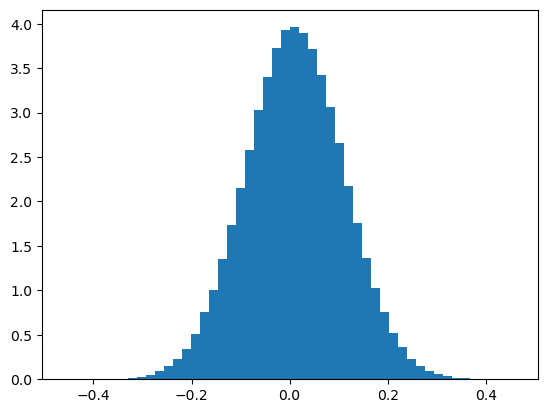

In [15]:
a = []
for i in range(500000):
    w = np.random.normal(0,.5)
    y = (.04-(.2**2)*.5)*.5+.2*w
    a.append(y)
plt.hist(a,50, density ='True')[2]

<BarContainer object of 50 artists>

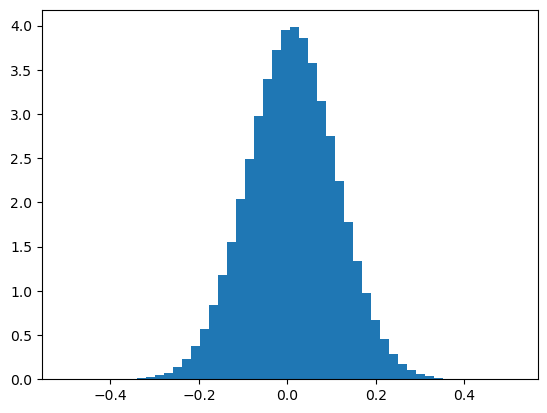

In [16]:
x = []
for i in range(500000):
    w = np.random.normal((.04-(.2**2)*.5)*.5,.2*.5)
    x.append(w)
plt.hist(x,50, density ='True')[2]

(ii) We start with the equation for the stock price at N
\begin{equation}
S_{N} = S_{0}u^{X}d^{(N-X)}
\\ where \ X \sim Bin(N,q)
\end{equation}
from this we get 
\begin{equation}
\frac{S_{N}}{S_{0}} = u^{X}d^{(N-X)}
\\ 
log(\frac{S_{N}}{S_{0}}) = log(u^{X}d^{(N-X)})
\\
log(u^{X}d^{(N-X)}) = log(u^{X})+log(d^{(N-X)})
\\ = Xlog(u)+(N-X)log(d)
\\ = Nlog(d)+X(log(u)-log(d))
\\ log(\frac{S_{N}}{S_{0}}) = Nlog(d)+Xlog(\frac{u}{d})
\end{equation}

<BarContainer object of 6 artists>

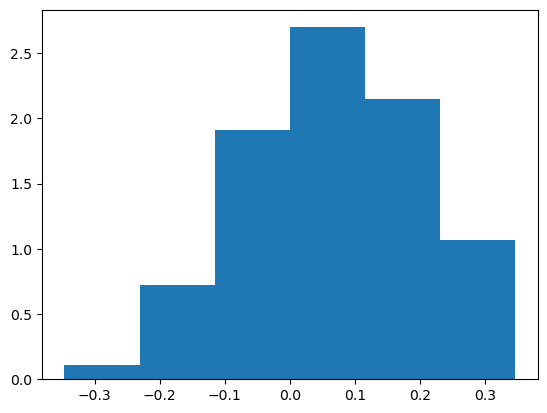

In [17]:
N = 6
T=.5
sigma = .2
r = .04
delta_t = T/N
u, d, p = calc_parameters(sigma, r, delta_t)
x = np.log(u/d) * np.random.binomial(N, p, 10000000)+N*np.log(d)
plt.hist(x ,6, density ='True')[2]

<BarContainer object of 25 artists>

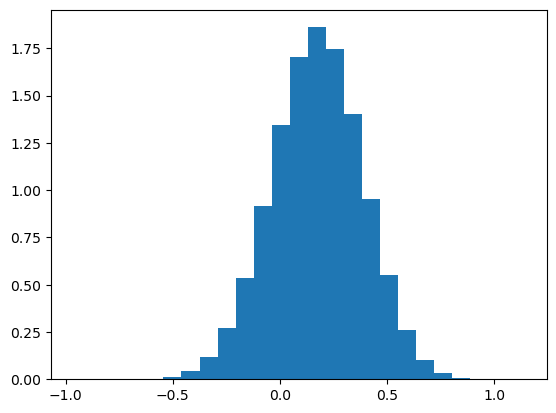

In [34]:
N = 26
delta_t = T/N
u, d, p = calc_parameters(sigma, r, delta_t)
y = np.log(u/d) * np.random.binomial(N, p, 10000000)+N*np.log(d)
plt.hist(y,25, density ='True')[2]

<BarContainer object of 125 artists>

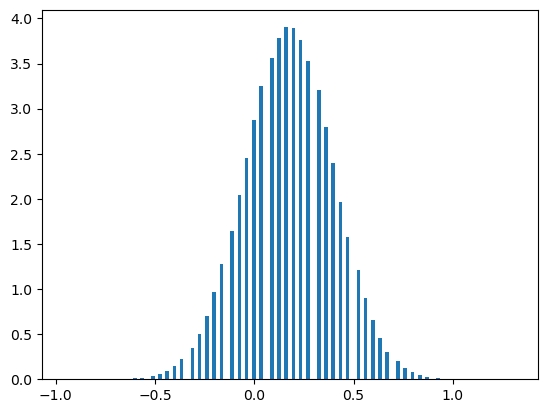

In [35]:
N = 126
delta_t = T/N
u, d, p = calc_parameters(sigma, r, delta_t)
z = np.log(u/d) * np.random.binomial(N, p, 10000000)+N*np.log(d)
plt.hist(z,125, density ='True')[2]

(iii)
Yes. As you can see below as N increases, the steps get smaller and approximate the log returns much better which makes sense.

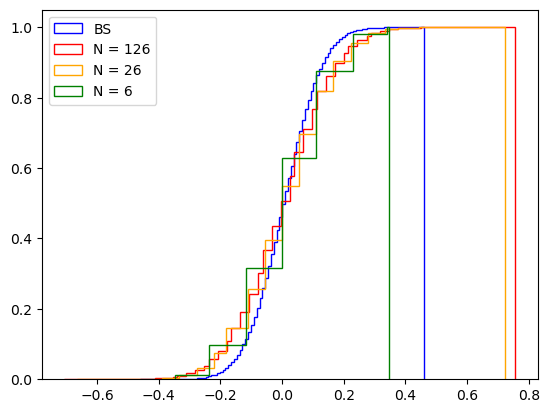

In [20]:
plt.hist(a,100, density ='True', cumulative =True, histtype= 'step', color ='blue', label = 'BS')
plt.hist(z,100, density ='True', cumulative =True, histtype= 'step', color ='red', label ='N = 126')
plt.hist(y,100, density ='True', cumulative =True, histtype= 'step', color = 'orange', label ='N = 26')
plt.hist(x,100, density ='True', cumulative =True, histtype= 'step', color ='green', label ='N = 6')
plt.legend()
plt.show()

# Problem 3
a. The exercise boundary refers to the points of an American put option where it makes sense to exercise the option early. This occurs because put options are capped on the upside potential since the maximum the stock can fall is to 0. This leads to points where the continuation value is lower than the value that can be received exercising at a time before since the stock is sufficiently low and there is not a greater expected value of holding the option longer since there is more potential for the stock to go up causing you to lose money and there is not enough value in another down move that it is worth the risk.
<br> <br>
c. As the volatility increases, the exercise boundary decreases. This is because there is more downside potential with higher volatility thus inflating the continuation value in many places. This then makes it unoptimal to exercise at more points correlating with a lower exercise boundary.
<br> <br>
d. For a callable option
\begin{equation}
V_{n,k} = min( max(e^{-r \Delta t}(pV_{n+1,k+1} + (1-p)V_{n+1,k}), K-S_{n,k}), max(H,K-S_{n,k}))  \text{ where H is the agreed upon repurchase price}
\end{equation}
because we see six scenarios
\begin{equation}
\text{Continuation Value} = e^{-r \Delta t}(pV_{n+1,k+1} + (1-p)V_{n+1,k}) \\
\color{blue} 1. H > \text{Continuation Value} > K-S_{n,k} \text{, the seller, buyer doesn't exercise, the value of this node is the }\underline{Continuation \ Value}\\ max(\text{Continuation Value}, K-S_{n,k}) = \text{Continuation Value}, \ max(H, K-S_{n,k}) = H, \ min(\text{Continuation Value}, H) = \underline{Continuation \ Value}\\
\color{blue} 2. \text{Continuation Value} > H >  K-S_{n,k} \text{, the seller exercises, buyer opts for payoff H, the value of this node is }\underline{H}\\ max(\text{Continuation Value}, K-S_{n,k}) = \text{Continuation Value}, \ max(H, K-S_{n,k}) = H , \ min(\text{Continuation Value}, H) = \underline{H}\\
\color{blue} 3. \text{Continuation Value}>  K-S_{n,k} > H \text{, the seller exercises, buyer exercises, the value of this node is }\underline {K-S_{n,k}}\\ max(\text{Continuation Value}, K-S_{n,k}) = \text{Continuation Value},\ max(H, K-S_{n,k}) = K-S_{n,k}, \ min(\text{Continuation Value}, K-S_{n,k}) =\underline {K-S_{n,k}}\\
\color{blue} 4. H > K-S_{n,k} > \text{Continuation Value} \text{, only buyer exercises, the value of this node is }\underline {K-S_{n,k}}\\ max(\text{Continuation Value}, K-S_{n,k}) = K-S_{n,k},\ max(H, K-S_{n,k}) = H, \ min(K-S_{n,k}, H) = \underline {K-S_{n,k}}\\
\color{blue} 5. K-S_{n,k} > H > \text{Continuation Value} \text{, only buyer exercises, the value of this node is }\underline {K-S_{n,k}}\\ max(\text{Continuation Value}, K-S_{n,k}) = K-S_{n,k},\ max(H, K-S_{n,k}) = K-S_{n,k}, \ min(K-S_{n,k}, K-S_{n,k}) = \underline {K-S_{n,k}}\\
\color{blue} 6. K-S_{n,k} > \text{Continuation Value} > H \text{, both exercise, the value of this node is }\underline {K-S_{n,k}}\\ max(\text{Continuation Value}, K-S_{n,k}) = K-S_{n,k},\ max(H, K-S_{n,k}) = K-S_{n,k}, \ min(K-S_{n,k}, K-S_{n,k}) = \underline {K-S_{n,k}}\\
\end{equation}
This piecewise equation satisfies all scenarios and accurately represents their payoffs. It is mainly the payoff for an American option, just with the seller being able to force the buyer to exercise early or receive a payoff H, thus the min portion.
<br>
This piecewise function
\begin{equation}
V_{n,k} =
\begin{cases}
max(e^{-r \Delta t}(pV_{n+1,k+1} + (1-p)V_{n+1,k}), K-S_{n,k}) & \text{if } e^{-r \Delta t}(pV_{n+1,k+1} + (1-p)V_{n+1,k}) < H \\
max(H,K-S_{n,k}) & \text{if } e^{-r \Delta t}(pV_{n+1,k+1} + (1-p)V_{n+1,k}) > H 
\end{cases}
\end{equation}
also works because when the continuation value is greater than the price to buy the option back, the seller can force the hand of the buyer to either take payoff H or to exercise. Thus it has the second payoff of the piecewise function. If the continuation value is lower than the price to buy the option back it makes no sense for the seller to exercise this. Thus it behaves like a normal american put option.

In [21]:
def amer_binomial_tree(S_0, sigma, r, K, T, N, option_type):
    delta_t = T/N
    step_disc_fact = np.exp(-r*delta_t)
    u, d, p = calc_parameters(sigma, r, delta_t)
    final_val =[]
    stock_prices = []
    exercises = []
    
    i=N
    while (i >= 0): 
        vals = []
        prices = []
        exercise = []
        for j in range(i+1):
            stock_price = S_0*(u**j)*(d**(i-j))
            if i==N:
                if option_type == 'call':
                    val = max(stock_price - K, 0)
                    
                else: 
                    val = max(K - stock_price, 0)
                if val == 0:
                    exer = 0  
                else:
                    exer = 1
            else: 
                if option_type == 'call':
                    exercise_price = max(stock_price - K, 0)
                else: 
                    exercise_price = max(K - stock_price, 0)
                val = 1
                val = step_disc_fact * ((1-p)*final_val[N-i-1][j]+(p)*final_val[N-i-1][j+1])
                
                if exercise_price > val:
                    exer = 1
                    val = exercise_price
                else:
                    exer = 0
            
            exercise.append(exer)
            prices.append(stock_price)
            vals.append(val)    
        stock_prices.append(prices)
        final_val.append(vals)
        exercises.append(exercise)
        i-=1
    
    return final_val, stock_prices, exercises , final_val[-1][0]

In [22]:
S_0 = 100
K= 100
T=5
sigma = .1
r = .04
option_type = 'puts'
div = 0
N=500
value_paths, stock_paths, exercise_locations, price = amer_binomial_tree(S_0, sigma, r, K, T, N, option_type)
price

3.878479099060788

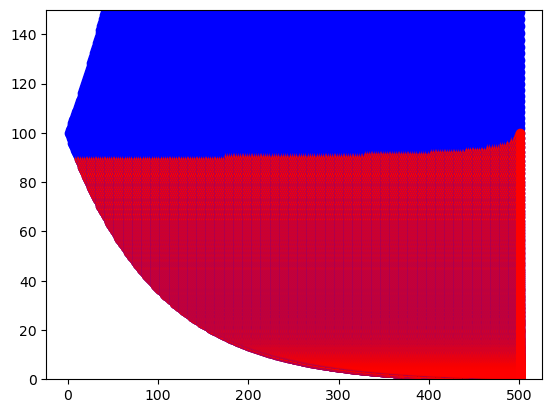

In [23]:
exercise_pts = []
for i in range(len(exercise_locations)):
    pts = np.multiply(exercise_locations[i], stock_paths[i])
    pts = pts[pts != 0]
    exercise_pts.append(pts)
for i in range(N+1):
    plt.scatter(np.full(i+1,i+1),stock_paths[N-i], color ='blue')   
    plt.scatter(np.full(len(exercise_pts[N-i]),i+1), exercise_pts[N-i], color = 'red')
    plt.ylim(0,150)

In [24]:
sigma = .3
value_paths, stock_paths, exercise_locations, price = amer_binomial_tree(S_0, sigma, r, K, T, N, option_type)
price

18.505292508706365

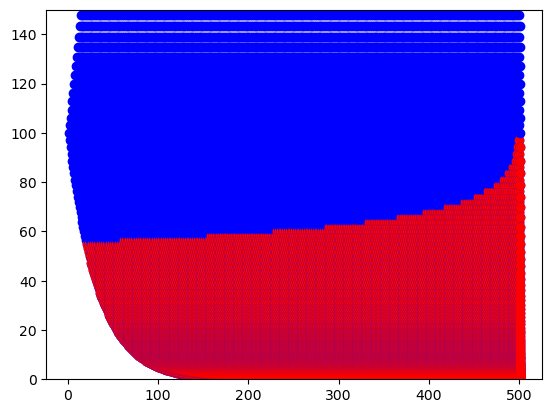

In [25]:
exercise_pts = []
for i in range(len(exercise_locations)):
    pts = np.multiply(exercise_locations[i], stock_paths[i])
    pts = pts[pts != 0]
    exercise_pts.append(pts)
for i in range(N+1):
    plt.scatter(np.full(i+1,i+1),stock_paths[N-i], color ='blue')   
    plt.scatter(np.full(len(exercise_pts[N-i]),i+1), exercise_pts[N-i], color = 'red')
    plt.ylim(0,150)

In [26]:
sigma = .5
value_paths, stock_paths, exercise_locations, price = amer_binomial_tree(S_0, sigma, r, K, T, N, option_type)
price

33.2788960461985

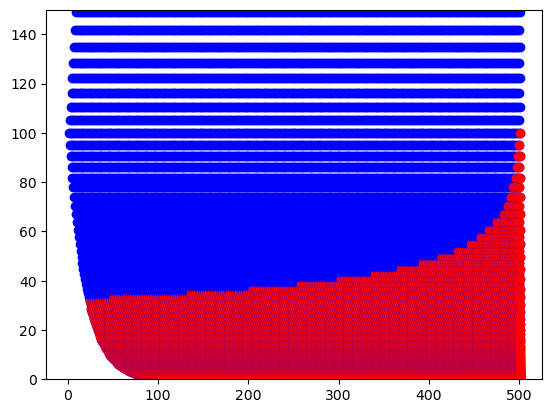

In [27]:
exercise_pts = []
for i in range(len(exercise_locations)):
    pts = np.multiply(exercise_locations[i], stock_paths[i])
    pts = pts[pts != 0]
    exercise_pts.append(pts)
for i in range(N+1):
    plt.scatter(np.full(i+1,i+1),stock_paths[N-i], color ='blue')   
    plt.scatter(np.full(len(exercise_pts[N-i]),i+1), exercise_pts[N-i], color = 'red')
    plt.ylim(0,150)

In [28]:
S_0 = 100
K= 100
T=5
sigma = .1
r = .04
option_type = 'puts'
div = 0
N=5
value_paths, stock_paths, exercise_locations, price = amer_binomial_tree(S_0, sigma, r, K, T, N, option_type)
price

3.766651957532072

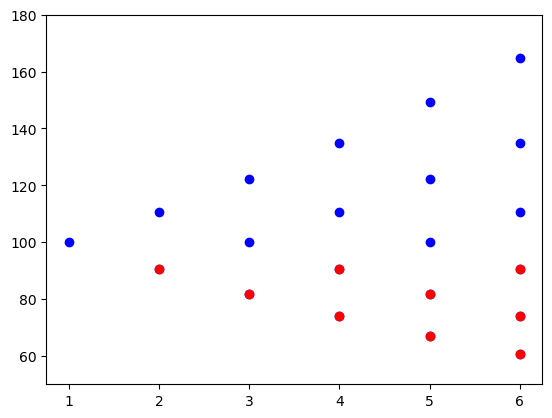

In [29]:
exercise_pts = []
for i in range(len(exercise_locations)):
    pts = np.multiply(exercise_locations[i], stock_paths[i])
    pts = pts[pts != 0]
    exercise_pts.append(pts)
for i in range(N+1):
    plt.scatter(np.full(i+1,i+1),stock_paths[N-i], color ='blue')   
    plt.scatter(np.full(len(exercise_pts[N-i]),i+1), exercise_pts[N-i], color = 'red')
    plt.ylim(50,180)

## Problem 4

a. payoff function is
\begin{equation}
V = (S_{T} - K)^{+} \mathbb{1} \{ \underset{0 \leq t \leq T} {min} \ S_{t} < H\}
\end{equation}
b. In order for the payoff to be positve, we must be knocked in by going down below the barrier H and then up above the strike price K to have a valid payoff
<br><br>
c. 0 denotes not being knocked in yet and 1 denotes being knocked in
\begin{equation}
V^{0}_{n,k} =
\begin{cases}
e^{-r \Delta t}( pV^{0}_{n+1,k+1} + (1-p)V^{1}_{n+1,k}) & \text{if } S_{n+1,k} < H & \text{(Cross Barrier)}\\
e^{-r \Delta t}( pV^{0}_{n+1,k+1} + (1-p)V^{0}_{n+1,k}) & \text{if } S_{n+1,k} > H & \text{(Doesn't Cross Barrier)}
\end{cases}
\end{equation}

\begin{equation}
V^{1}_{n,k} = e^{-r \Delta t}( pV^{1}_{n+1,k+1} + (1-p)V^{1}_{n+1,k})
\end{equation}
At the end points we have 
\begin{equation}
V^{1}_{n,k} = max(S_{n,k} - K, 0) \\
V^{0}_{n,k} = 0
\end{equation}
<br>
d. It converges slower than non-barrier options to attain comprable accuracy. This is because when close to the barrier the tree needs to have sufficiently small d or u with large N so that you can accurately predict how it reacts close to the barrier. If it is too large then you can jump too far below the barrier or above the barrier to accurately represent the possibility it just touches the barrier and gets knocked in and then rebounds. So you need large N to represent touching the barrier and finding the expected value from there. There may be some situations where you don't touch the barrier if the value of the node is 91 when the barrier is at 90 and then the next node maybe is at 85 and you do not have a good representation of the values of the nodes around the barrier. When you increase N though you can make u,d able to change the stock price much finer and can accurately find it. Because of this you need a higher N than with no barrier so it converges slower.
<br><br>
e. (i) The prices and deltas of Parisian options are less sensitive because it must spend a prolonged period under or above the barrier. Thus when it is close to the barrier it has to be there for a prolonged period of time so you do not have to worry about the cases of just touching and then bouncing up taking away some of the sensitvity. We only have to account for the cases that it is there for a prolonged period of time which is more robust since the prices and deltas are less volatile when you have to be below or above for long periods.
<br>
(ii) You can use d + 1 state variables that indicates whether or not the Parisian down-and-in call option was below the barrier in the future d periods. Thus when you are using a binomial tree, all the end points that have not been knocked in are equal to 0 and the ones that are it is a call option. From here we go back and for a node we have two payoffs, one where it is knocked in already and one where it is not. If it is we can treat this as a call option with dynamic programming. If it is not knocked in we can use our state variables to look at if we are currently below the barrier, how many periods we have been below the barrier for and then we can look at the expected value of the payoffs for this node.  